In [2]:
import torch.nn as nn
import torch
from kan import *

# get gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# first we define the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # define the layers
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # define the forward pass
        out = self.network(x)
        return out
    
# KAN with 768 input dimensions, 3 layers of 256 hidden dimensions, and 10 output dimensions
# other values are from hellokan notebook. Kinda afraid that the model is too big, as they
# used width=[2,5,1] albeit for just modelling an equation.
model = KAN(width=[768, 256, 256, 256, 10], grid=5, k=3, seed=0)

In [3]:
# now we grab the dataset. We will use the MNIST dataset

from torchvision import transforms, datasets

training_data = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())


Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])
Label:  tensor(4)


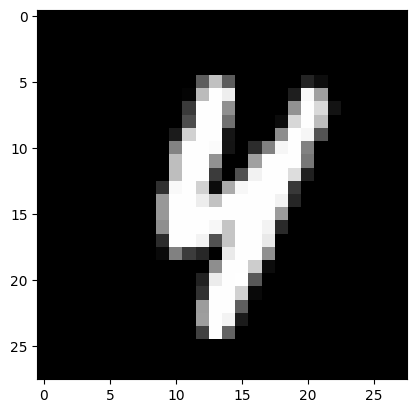

In [4]:
# print some dataset stats and a sample.
import matplotlib.pyplot as plt
import random

print("Training data shape: ", training_data.data.shape)
print("Training labels shape: ", training_data.targets.shape)
print("Test data shape: ", test_data.data.shape)
print("Test labels shape: ", test_data.targets.shape)

# plot a sample
data_point = random.randint(0, len(training_data.data))
plt.imshow(training_data.data[data_point].numpy(), cmap="gray")
print("Label: ", training_data.targets[data_point])

In [5]:
from torch.utils.data import DataLoader

# load data in batch size of 128, using gpu if available

training_batch_size = 128
test_batch_size = 1000
train_loader = DataLoader(training_data, batch_size=training_batch_size, shuffle=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, generator=torch.Generator(device=device))

In [8]:
from torch.optim import Adam
import time
# training loop

model = MLP(784, 256, 10).to(device)

# define the loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# loop
num_epochs = 25
for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    # start timer
    time_start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # move to gpu
        images = images.to(device)
        labels = labels.to(device)

        # flatten the images
        images = images.view(images.shape[0], -1)

        # forward pass
        outputs = model(images)

        # loss
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print loss every 100 steps
        if i % 100 == 0:
            print("Step: ", i, " Loss: ", loss.item())
    time_end = time.time()
    print("Epoch time: ", time_end - time_start)

Epoch:  0
Step:  0  Loss:  2.2996671199798584
Step:  100  Loss:  0.32024434208869934
Step:  200  Loss:  0.23602798581123352
Step:  300  Loss:  0.116938017308712
Step:  400  Loss:  0.20604899525642395
Epoch time:  9.064204692840576
Epoch:  1
Step:  0  Loss:  0.12408554553985596
Step:  100  Loss:  0.15936365723609924
Step:  200  Loss:  0.16739529371261597
Step:  300  Loss:  0.08646479994058609
Step:  400  Loss:  0.10784514248371124
Epoch time:  8.986098766326904
Epoch:  2
Step:  0  Loss:  0.07703375816345215
Step:  100  Loss:  0.06325145810842514
Step:  200  Loss:  0.09653902053833008
Step:  300  Loss:  0.0937098041176796
Step:  400  Loss:  0.00904614757746458
Epoch time:  8.583059310913086
Epoch:  3
Step:  0  Loss:  0.03117375820875168
Step:  100  Loss:  0.06702212989330292
Step:  200  Loss:  0.09608977288007736
Step:  300  Loss:  0.0624086856842041
Step:  400  Loss:  0.027423640713095665
Epoch time:  7.83612322807312
Epoch:  4
Step:  0  Loss:  0.013015949167311192
Step:  100  Loss:  0.

In [9]:
import torch
torch.save(model.state_dict(), 'pytorch_mlp_mnist_25epoch.pth')


Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])
Label:  tensor(0)
Prediction:  0


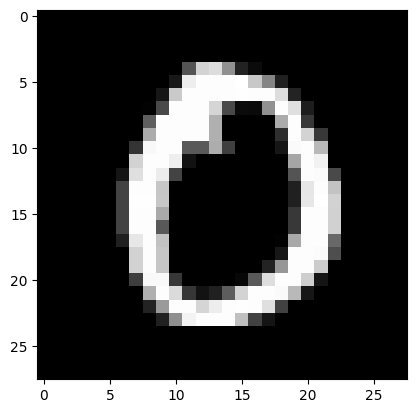

In [36]:
# test the model on a random sample
print("Training data shape: ", training_data.data.shape)
print("Training labels shape: ", training_data.targets.shape)
print("Test data shape: ", test_data.data.shape)
print("Test labels shape: ", test_data.targets.shape)

# plot a sample
data_point = random.randint(0, len(training_data.data))
plt.imshow(training_data.data[data_point].numpy(), cmap="gray")
print("Label: ", training_data.targets[data_point])

with torch.inference_mode():
    result = model.forward(training_data.data[data_point].view(1, -1).to(device, dtype=torch.float32))
    print("Prediction: ", torch.argmax(result).item())